In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd 
color_dict = {
    "Eggshell": "#f4f1de",
    "Burnt sienna": "#e07a5f",
    "Delft Blue": "#3d405b",
    "Cambridge blue": "#81b29a",
    "Sunset": "#f2cc8f",
}

# Use LaTeX fonts for a professional look
plt.rcParams.update(
    {
        "text.usetex": True,  # Use LaTeX for text rendering
        "font.family": "serif",  # Use serif fonts
    }
)

# Set seaborn style for better aesthetics
# sns.set_style("whitegrid")

## Extract across Merges

In [2]:
name_mapping = {
    'random': 'Random',
    'irt': 'IRT',
    'rc': 'Representation Clustering',
    'pirt': 'p-IRT',
    'gpirt': 'gp-IRT',
    'mpirt': 'mp-IRT',
    'gmpirt': 'gmp-IRT',
}

In [3]:
# ----------------------------------------------------------------------
# Read data
# ------------------------------------------------------------------------
# Example file names; adjust as needed
df_all = pd.read_csv("data/estimate_merges.csv")

# rename column estimate_method to estimate_method
df_all = df_all.rename(columns={"estimate_method": "estimate_method"})

In [4]:
# rename 
df_all['estimate_method'] = df_all['estimate_method'].map(name_mapping)

df_all.dropna(inplace=True)


In [5]:
df_all

,merge,n_samples,accuracy,estimate_method,iter,diff
0,arithmo_meta_slerp,10,0.700000,Random,0,0.012661
1,arithmo_meta_slerp,10,0.900000,Random,1,0.187339
2,arithmo_meta_slerp,10,0.800000,Random,2,0.087339
3,arithmo_meta_slerp,10,0.600000,Random,3,0.112661
4,arithmo_meta_slerp,10,0.600000,Random,4,0.112661
...,...,...,...,...,...,...
2515,wizard_meta_td,100,0.642911,Representation Clustering,9,0.059894
2516,wizard_meta_td,100,0.582856,gmp-IRT,9,0.000162
2517,wizard_meta_td,100,0.642911,IRT,9,0.059894
2518,wizard_meta_td,100,0.502107,p-IRT,9,0.080911


estimate_methods in summary: ['IRT' 'Random' 'Representation Clustering' 'gmp-IRT' 'gp-IRT' 'mp-IRT'
 'p-IRT']


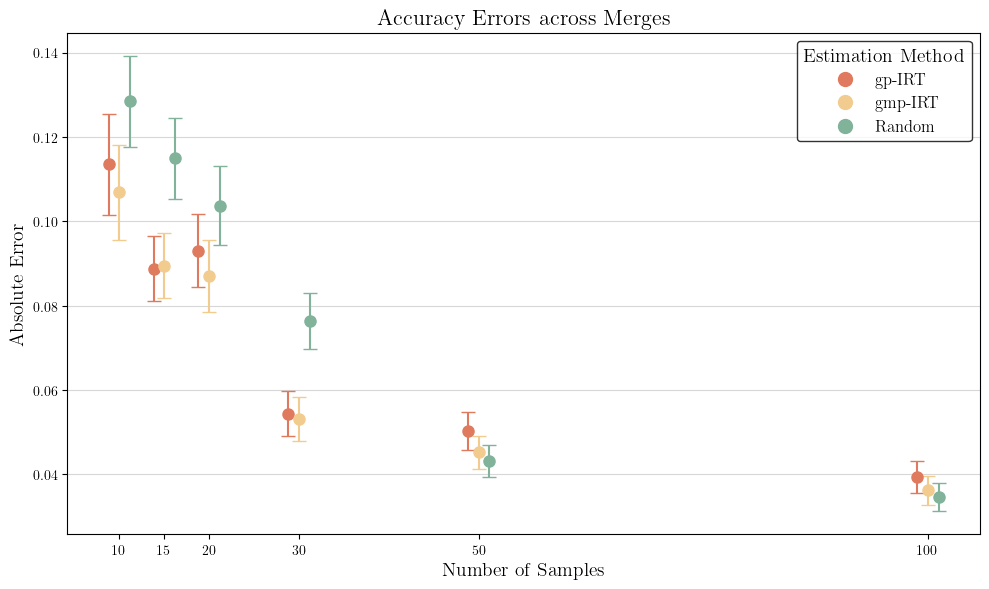

In [6]:
# Calculate the difference between true accuracy and estimated accuracy

hue_order = ['gp-IRT', 'gmp-IRT', 'Random']

# Define colors for the different estimate_methods
palette = {
    "Random": color_dict["Cambridge blue"],
    "gp-IRT": color_dict["Burnt sienna"],
    "gmp-IRT": color_dict["Sunset"],
    "p-IRT": color_dict["Burnt sienna"],
    "mp-IRT": color_dict["Sunset"],
}

OFFSET = 1.2

estimated_acc_df = df_all.copy()

# Fixed x-offsets for each method
offsets = {hue: i * OFFSET - OFFSET for i, hue in enumerate(hue_order)}  # Evenly spaced offsets around 0

# Calculate mean and standard error for each combination of `n_samples` and `estimate_method` across all merges
summary = estimated_acc_df.groupby(['n_samples', 'estimate_method']).agg(
    mean_diff=('diff', 'mean'),
    se_diff=('diff', lambda x: x.std() / np.sqrt(len(x)))
).reset_index()

# Debugging: Check unique estimate_methods in summary
print("estimate_methods in summary:", summary['estimate_method'].unique())

# Create a single plot
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot with error bars for each method
for j, m in enumerate(hue_order):
    subset = summary[summary['estimate_method'] == m]
    if subset.empty:  # Log if a subset is empty
        print(f"Warning: No data for estimate_method '{m}'")
        continue
    x_offset = offsets[m]  # Fixed offset based on method
    adjusted_x = subset['n_samples'] + x_offset
    ax.errorbar(adjusted_x, subset['mean_diff'], yerr=subset['se_diff'], fmt='o',
                label=m, color=palette[m], alpha=1., capsize=5, markersize=8)

# Set labels and title
ax.set_title('Accuracy Errors across Merges', fontsize=16)
ax.set_ylabel('Absolute Error', fontsize=14)
ax.set_xlabel('Number of Samples', fontsize=14)

# Set x ticks
ax.set_xticks(summary['n_samples'].unique())

# Customize legend
handles = [plt.Line2D([0], [0], marker='o', color=palette[t], linestyle='', markersize=10) for t in hue_order]
labels = hue_order
legend = ax.legend(handles, labels, title='Estimation Method', loc='best', fontsize=12, title_fontsize=14)
legend.get_frame().set_alpha(0.8)
legend.get_frame().set_linewidth(1.)
legend.get_frame().set_edgecolor('black')

# Add grid lines
ax.yaxis.grid(True, linestyle='-', alpha=0.5)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

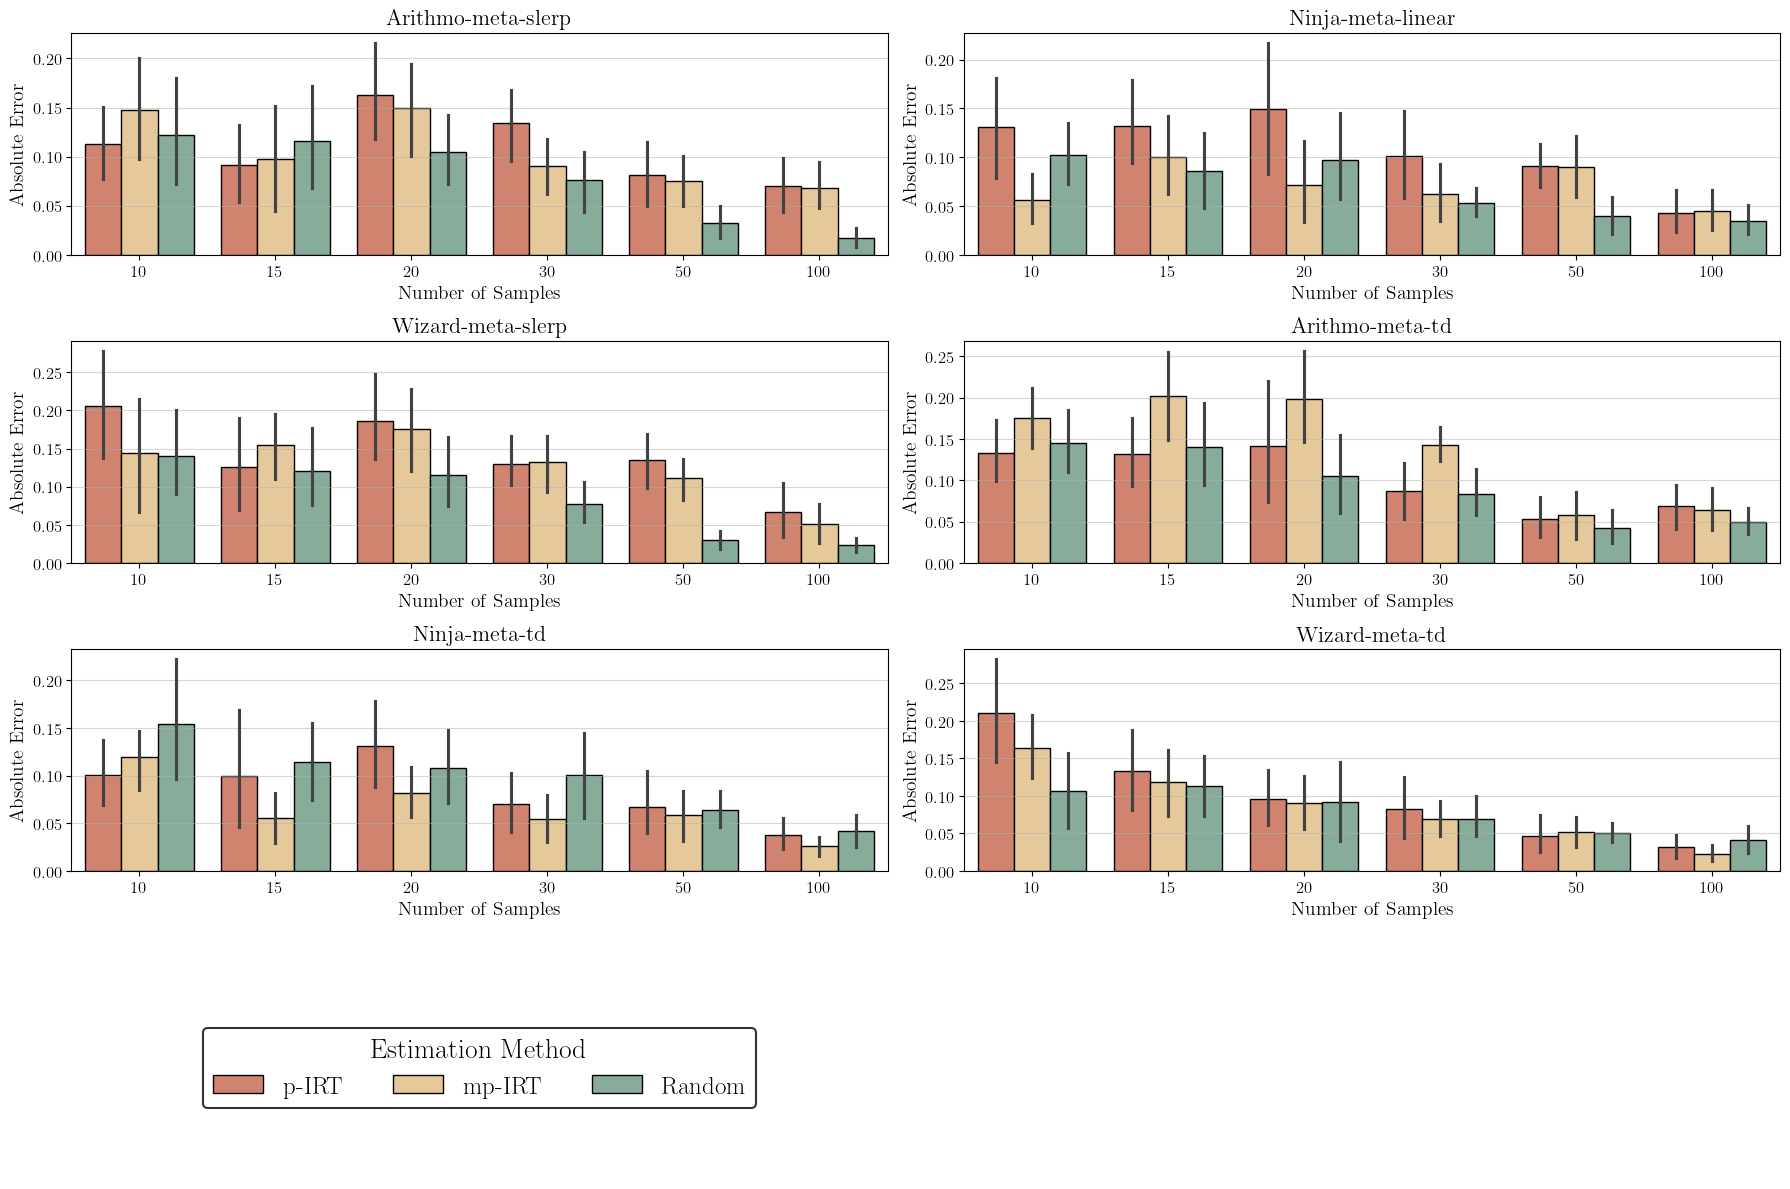

In [20]:
# Create a 3x2 layout of subplots
fig, axes = plt.subplots(4, 2, figsize=(18, 12))  # 3 rows and 2 columns
axes = axes.flatten()  # Flatten the 2D array to easily iterate over it

merges = estimated_acc_df['merge'].unique()  # Get unique mergeuages

# Iterate through each mergeuage and subplot axis
for i, merge in enumerate(merges):
    # Filter data for the specific mergeuage
    merge_data = estimated_acc_df[estimated_acc_df['merge'] == merge].copy()

    # Sort the data by hue_order to match the order of bars in the plot
    merge_data['estimate_method'] = pd.Categorical(merge_data['estimate_method'], categories=hue_order, ordered=True)
    merge_data = merge_data.sort_values('estimate_method')

    # Plot on the corresponding axis
    sns.barplot(
        x='n_samples', y='diff', hue='estimate_method', data=merge_data,
        palette=palette, hue_order=hue_order, edgecolor='black', linewidth=1., ax=axes[i])

    # Set the title for each subplot
    axes[i].set_title(f"{merge}".casefold().capitalize().replace('_', '-'), fontsize=18)

    # set font size for title
    axes[i].title.set_fontsize(16)

    # hide legend
    axes[i].get_legend().remove()

    # set y title to 'Absolute Error'
    axes[i].set_ylabel('Absolute Error')

    # set x title to 'Number of Samples'
    axes[i].set_xlabel('Number of Samples')

    # set font size for x and y labels
    axes[i].xaxis.label.set_fontsize(14)
    axes[i].yaxis.label.set_fontsize(14)

    # set font size for x and y ticks
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)

    # Add grid lines
    axes[i].yaxis.grid(True, linestyle='-', alpha=0.5)

# Add the legend to the last subplot
axes[-1].axis('off')  # Turn off the axis for the empty subplot
axes[-2].axis('off')  # Turn off the axis for the empty subplot
handles, labels = axes[0].get_legend_handles_labels()  # Get handles and labels from the first subplot

# Increase legend size by adjusting font size and label spacing
legend = axes[-2].legend(handles, labels, title='Estimation Method', loc='center', ncol=4, fontsize=18, title_fontsize=20)

# Optionally, increase the border and shadow of the legend for better visibility
legend.get_frame().set_alpha(0.8)  # Set transparency
legend.get_frame().set_linewidth(1.5)  # Set border linewidth
legend.get_frame().set_edgecolor('black')  # Set border color

# Adjust layout for better spacing
plt.tight_layout()

# Show the full plot
plt.show()


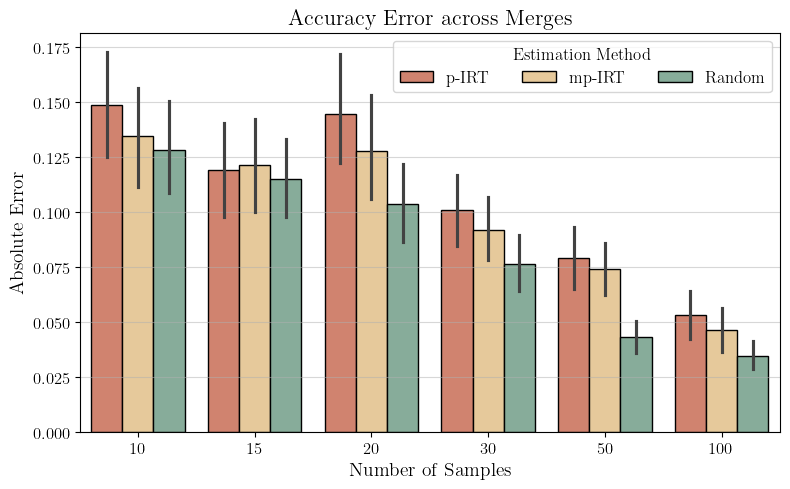

In [19]:
hue_order = ['p-IRT', 'mp-IRT', 'Random']

merges = estimated_acc_df['merge'].unique()

# Create a 3x2 layout of subplots
fig, ax = plt.subplots(1, 1, figsize=(8, 5))  # 3 rows and 2 columns

# Iterate through each mergeuage and subplot axis
# Filter data for the specific mergeuage
merge_data = estimated_acc_df.copy()

# Sort the data by hue_order to match the order of bars in the plot
merge_data['estimate_method'] = pd.Categorical(merge_data['estimate_method'], categories=hue_order, ordered=True)
merge_data = merge_data.sort_values('estimate_method')

# Plot on the corresponding axis
sns.barplot(
    x='n_samples', y='diff', hue='estimate_method', data=merge_data,
    palette=palette, hue_order=hue_order, edgecolor='black', linewidth=1., ax=ax)

# Set the title for each subplot
ax.set_title(f"Accuracy Error across Merges")

# set font size for title
ax.title.set_fontsize(16)

# hide legend
ax.get_legend().remove()

# set y title to 'Absolute Error'
ax.set_ylabel('Absolute Error')

# set x title to 'Number of Samples'
ax.set_xlabel('Number of Samples')

# set font size for x and y labels
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)

# set x and y ticks font size
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Increase legend size by adjusting font size and label spacing
ax.legend(title='Estimation Method', loc='upper right', ncol=4, fontsize=12, title_fontsize=12)

# Add grid lines
ax.yaxis.grid(True, linestyle='-', alpha=0.5)

# Adjust layout for better spacing
plt.tight_layout()

# Show the full plot
plt.show()

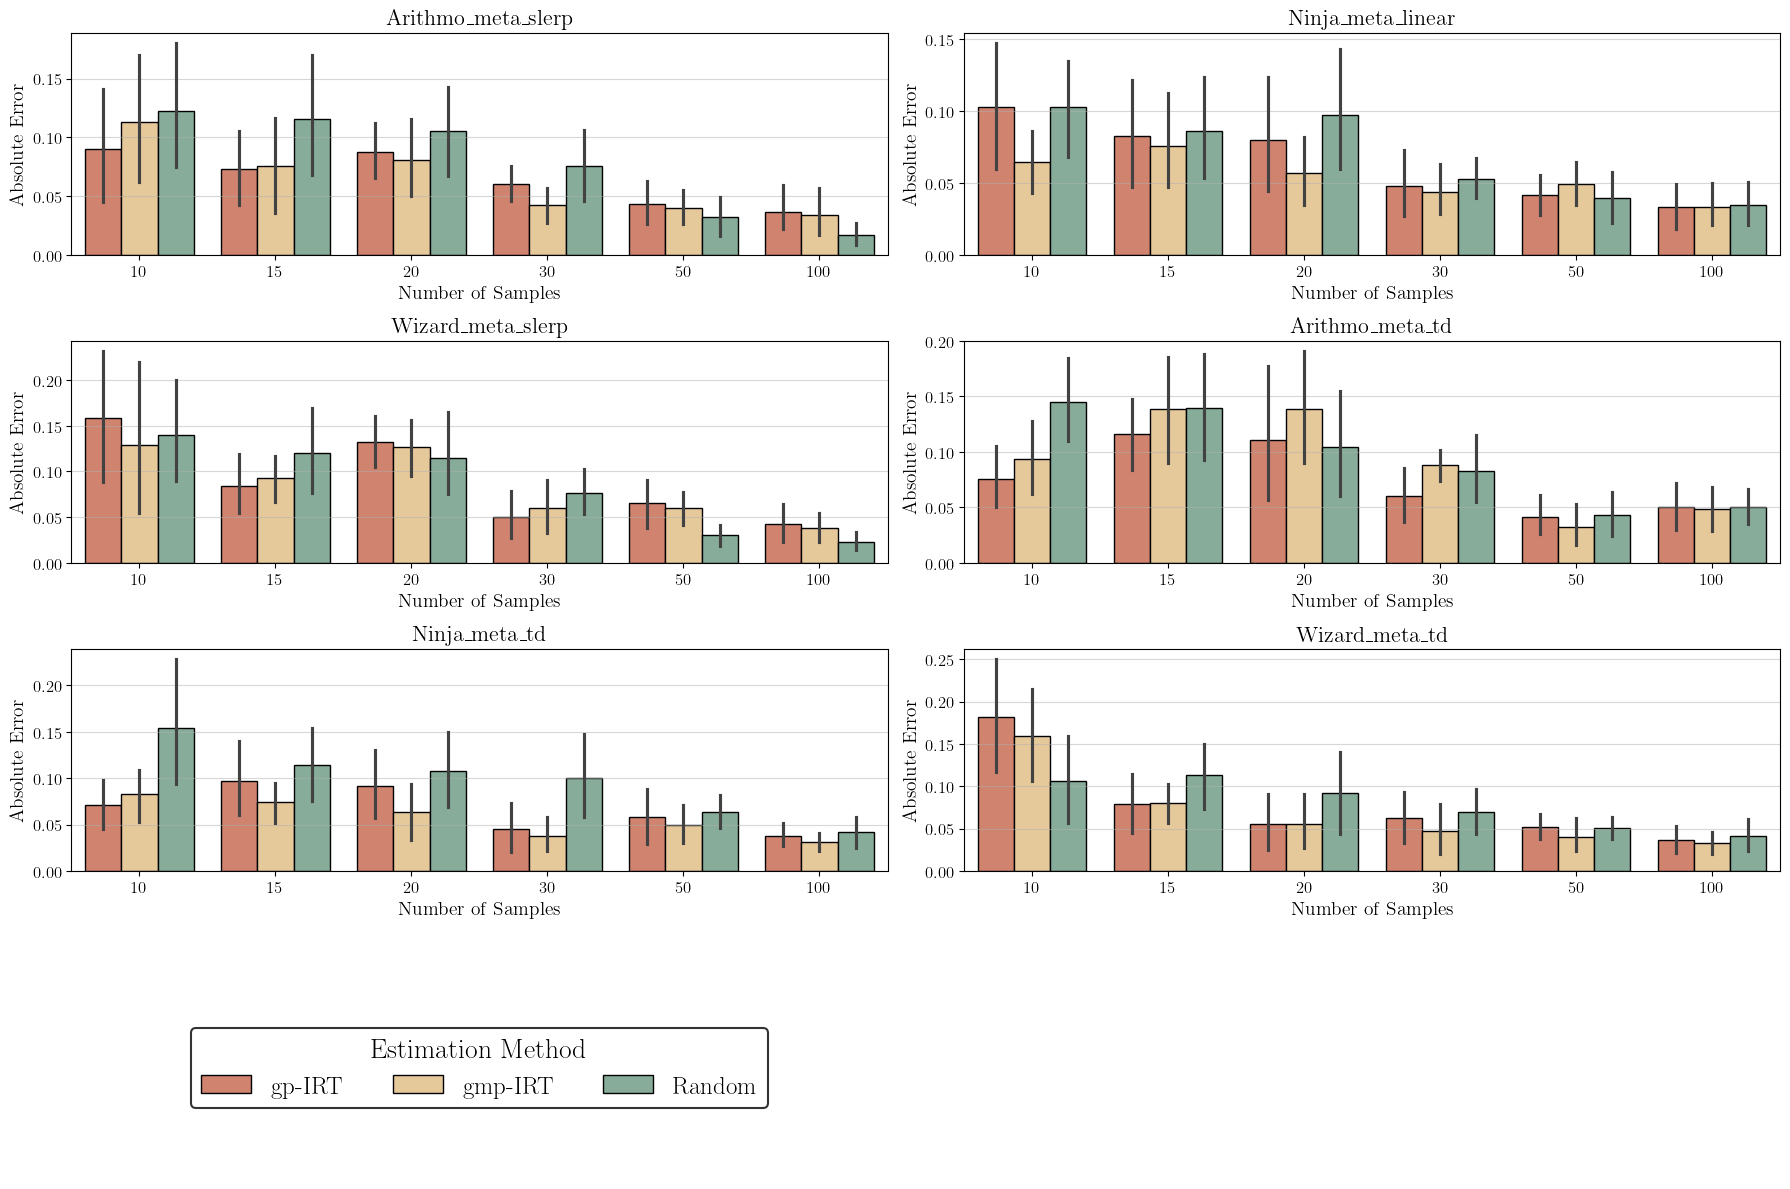

In [18]:
# Create a 3x2 layout of subplots
fig, axes = plt.subplots(4, 2, figsize=(18, 12))  # 3 rows and 2 columns
axes = axes.flatten()  # Flatten the 2D array to easily iterate over it

# Define colors for the different estimate_methods of methods

# Iterate through each mergeuage and subplot axis
for i, merge in enumerate(merges):
    # Filter data for the specific mergeuage
    merge_data = estimated_acc_df[estimated_acc_df['merge'] == merge].copy()

    # Sort the data by hue_order to match the order of bars in the plot
    merge_data['estimate_method'] = pd.Categorical(merge_data['estimate_method'], categories=hue_order, ordered=True)
    merge_data = merge_data.sort_values('estimate_method')

    # Plot on the corresponding axis
    sns.barplot(
        x='n_samples', y='diff', hue='estimate_method', data=merge_data,
        palette=palette, hue_order=hue_order, edgecolor='black', linewidth=1., ax=axes[i])

    # Set the title for each subplot
    axes[i].set_title(f"{merge}".casefold().capitalize())

    # set font size for title
    axes[i].title.set_fontsize(16)

    # hide legend
    axes[i].get_legend().remove()

    # set y title to 'Absolute Error'
    axes[i].set_ylabel('Absolute Error')

    # set x title to 'Number of Samples'
    axes[i].set_xlabel('Number of Samples')

    # set font size for x and y labels
    axes[i].xaxis.label.set_fontsize(14)
    axes[i].yaxis.label.set_fontsize(14)

    # set font size for x and y ticks
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)

    # Add grid lines
    axes[i].yaxis.grid(True, linestyle='-', alpha=0.5)

# Add the legend to the last subplot
axes[-1].axis('off')  # Turn off the axis for the empty subplot
axes[-2].axis('off')  # Turn off the axis for the empty subplot
handles, labels = axes[0].get_legend_handles_labels()  # Get handles and labels from the first subplot

# Increase legend size by adjusting font size and label spacing
legend = axes[-2].legend(handles, labels, title='Estimation Method', loc='center', ncol=4, fontsize=18, title_fontsize=20)

# Optionally, increase the border and shadow of the legend for better visibility
legend.get_frame().set_alpha(0.8)  # Set transparency
legend.get_frame().set_linewidth(1.5)  # Set border linewidth
legend.get_frame().set_edgecolor('black')  # Set border color

# Adjust layout for better spacing
plt.tight_layout()

# Show the full plot
plt.show()

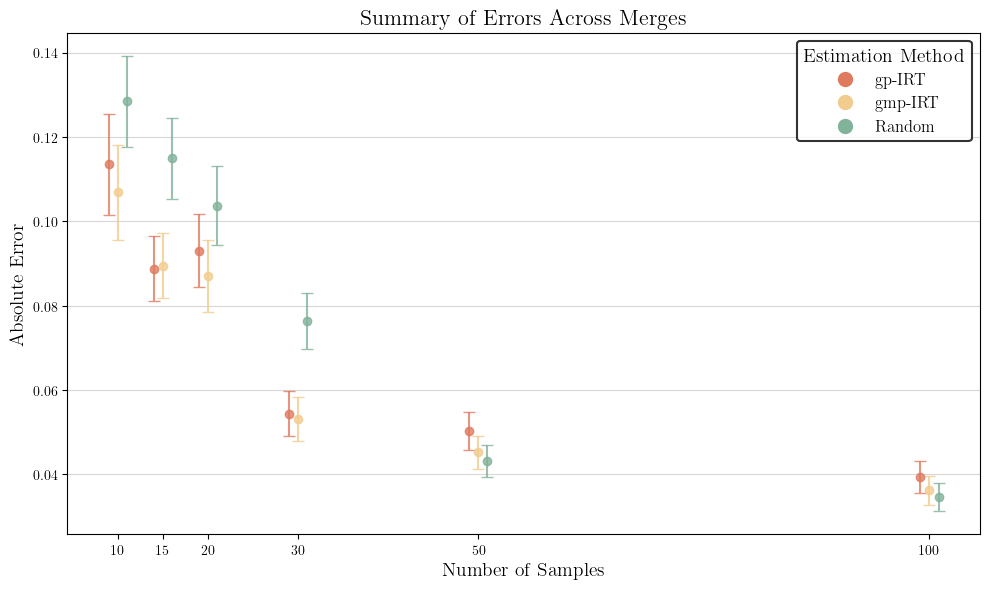

In [14]:
OFFSET = 1

hue_order = ['gp-IRT', 'gmp-IRT', 'Random']

# Fixed x-offsets for each method
offsets = {hue: i * OFFSET - OFFSET for i, hue in enumerate(hue_order)}  # Evenly spaced offsets around 0

# Calculate mean and standard error for each combination of `n_samples` and `estimate_method` across all merges
summary = estimated_acc_df.groupby(['n_samples', 'estimate_method']).agg(
    mean_diff=('diff', 'mean'),
    se_diff=('diff', lambda x: x.std() / np.sqrt(len(x)))
).reset_index()

# Create a single plot
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot with error bars for each method
for j, t in enumerate(hue_order):
    subset = summary[summary['estimate_method'] == t]
    x_offset = offsets[t]  # Fixed offset based on method
    adjusted_x = subset['n_samples'] + x_offset
    ax.errorbar(adjusted_x, subset['mean_diff'], yerr=subset['se_diff'], fmt='o',
                label=t, color=palette[t], alpha=0.8, capsize=4, markersize=6)

# Set labels and title
ax.set_title('Summary of Errors Across Merges', fontsize=16)
ax.set_ylabel('Absolute Error', fontsize=14)
ax.set_xlabel('Number of Samples', fontsize=14)

# Set x ticks
ax.set_xticks(summary['n_samples'].unique())

# Customize legend
handles = [plt.Line2D([0], [0], marker='o', color=palette[t], linestyle='', markersize=10) for t in hue_order]
labels = hue_order
legend = ax.legend(handles, labels, title='Estimation Method', loc='best', fontsize=12, title_fontsize=14)
legend.get_frame().set_alpha(0.8)
legend.get_frame().set_linewidth(1.5)
legend.get_frame().set_edgecolor('black')

# Add grid lines
ax.yaxis.grid(True, linestyle='-', alpha=0.5)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

/tmp/ipykernel_5563/1149042241.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = merge_data.groupby(['n_samples', 'estimate_method']).agg(
/tmp/ipykernel_5563/1149042241.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = merge_data.groupby(['n_samples', 'estimate_method']).agg(
/tmp/ipykernel_5563/1149042241.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = merge_data.groupby(['n_sam

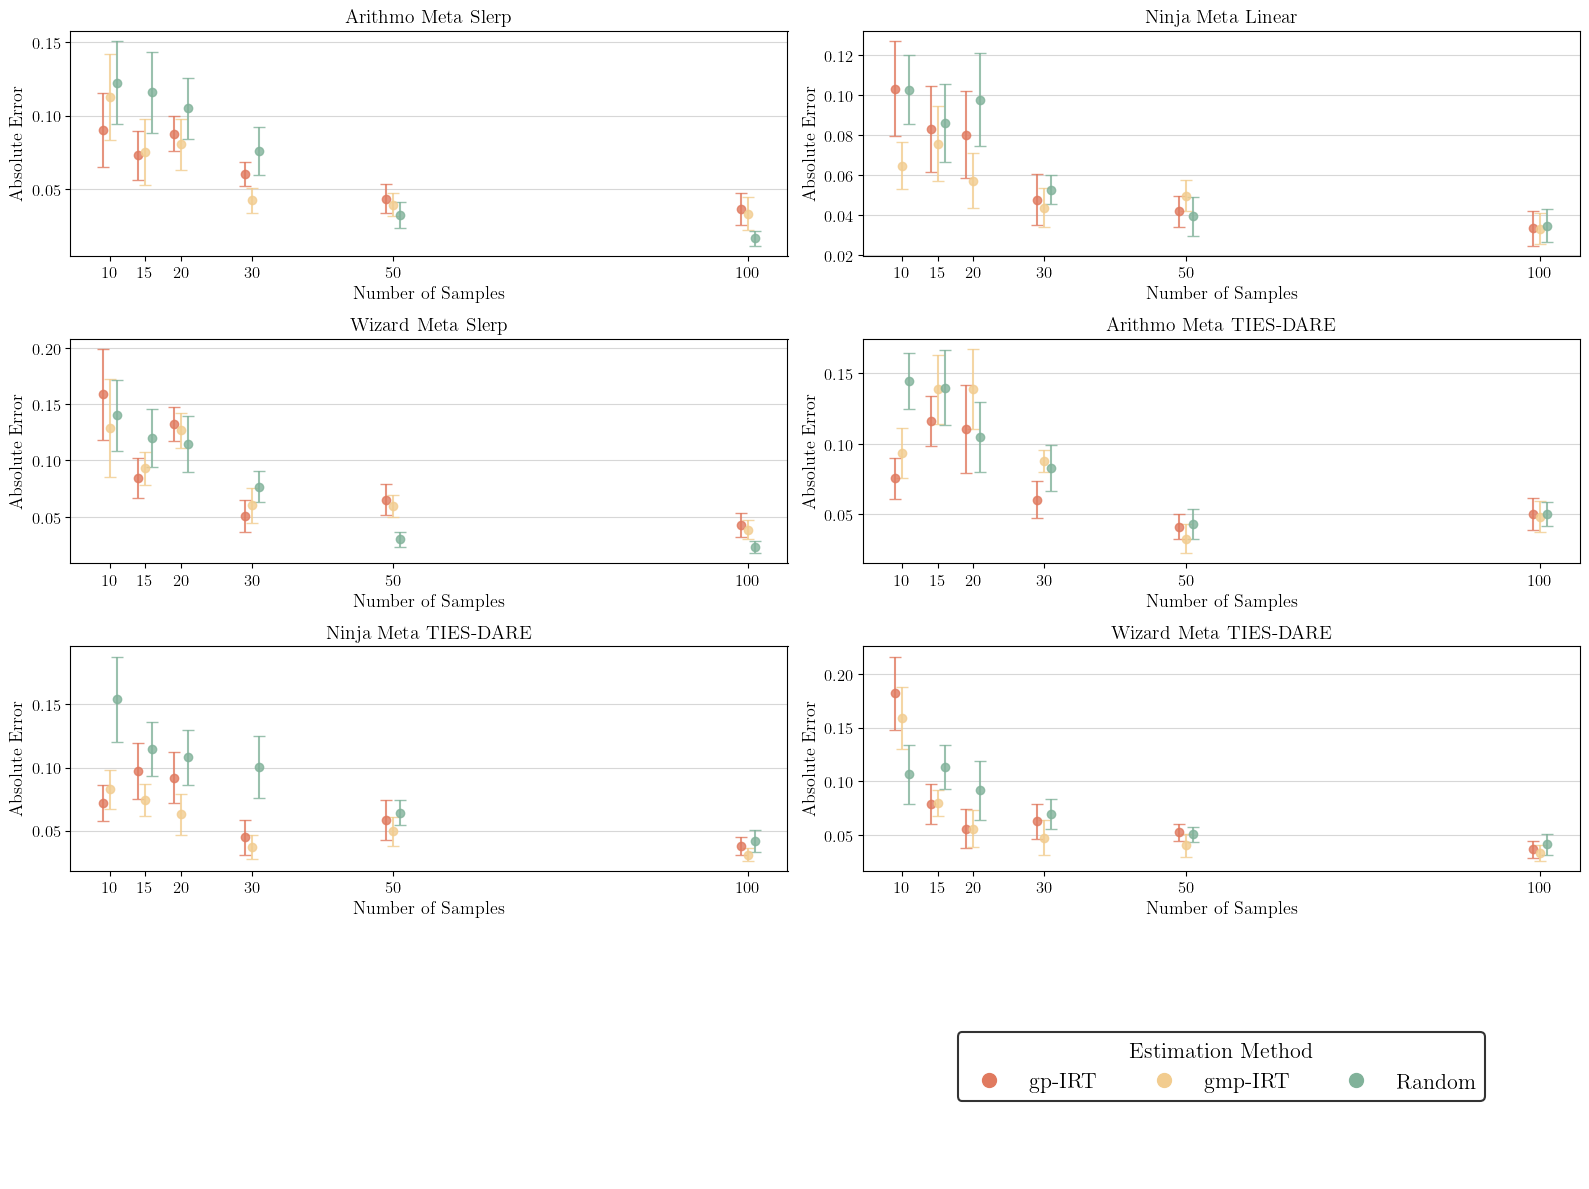

In [ ]:
merges = estimated_acc_df['merge'].unique()

# Create a 4x2 layout of subplots
fig, axes = plt.subplots(4, 2, figsize=(16, 12))  # 4 rows and 2 columns
axes = axes.flatten()  # Flatten the 2D array to easily iterate over it

OFFSET = 1

# Fixed x-offsets for each method
offsets = {hue: i * OFFSET - OFFSET for i, hue in enumerate(hue_order)}  # Evenly spaced offsets around 0

for i, merge in enumerate(merges):
    merge_data = estimated_acc_df[estimated_acc_df['merge'] == merge].copy()

    # Sort the data by hue_order to maintain consistent coloring
    merge_data['estimate_method'] = pd.Categorical(merge_data['estimate_method'], categories=hue_order, ordered=True)

    # Calculate mean and standard error for each combination of `n_samples` and `estimate_method`
    summary = merge_data.groupby(['n_samples', 'estimate_method']).agg(
        mean_diff=('diff', 'mean'),
        se_diff=('diff', lambda x: x.std() / np.sqrt(len(x)))
    ).reset_index()

    # Scatter plot with error bars
    for j, t in enumerate(hue_order):
        subset = summary[summary['estimate_method'] == t]
        x_offset = offsets[t]  # Fixed offset based on method
        adjusted_x = subset['n_samples'] + x_offset
        axes[i].errorbar(adjusted_x, subset['mean_diff'], yerr=subset['se_diff'], fmt='o',
                            label=t, color=palette[t], alpha=0.8, capsize=4, markersize=6)

    # Set the title for each subplot
    axes[i].set_title(f"{merge}".replace('_', ' ').title().replace('Td', 'TIES-DARE'))

    # Set labels
    axes[i].set_ylabel('Absolute Error')
    axes[i].set_xlabel('Number of Samples')

    # Set font sizes
    axes[i].title.set_fontsize(14)
    axes[i].xaxis.label.set_fontsize(13)
    axes[i].yaxis.label.set_fontsize(13)
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)

    # set x values to the unique values of n_samples
    axes[i].set_xticks(summary['n_samples'].unique())

    # add grid lines
    axes[i].yaxis.grid(True, linestyle='-', alpha=0.5)

# Global legend
handles = [plt.Line2D([0], [0], marker='o', color=palette[m], linestyle='', markersize=10) for m in hue_order]
labels = hue_order
axes[-1].axis('off')  # Hide axis
axes[-2].axis('off')  # Hide axis
legend = axes[-1].legend(handles, labels, title='Estimation Method', loc='center', ncol=4, fontsize=16, title_fontsize=16)
legend.get_frame().set_alpha(0.8)
legend.get_frame().set_linewidth(1.5)
legend.get_frame().set_edgecolor('black')

# Adjust layout
plt.tight_layout()
plt.show()